# Python vs. Numpy vs. TensorFlow

This notebook introduces some of the concepts in numerical computing in Python. More specifically, it will go through a very simple example of reducing table sums, first with vanilla Python loops, and then with Numpy and TensorFlow, and compare the performance of those two together.

The goal is to get a sense of why we use libraries such as Numpy/TensorFlow, and understand how the basics of how those are implemented.

## Setup
Imports, constant, and some other setup.

In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial
import timeit
from benchmarks import (
    TableTestNp, 
    TableTestPy,
    TableTestTf,
    MatPowTestNp,
    MatPowTestTf,
)
from visualization import plot_with_legend

import tensorflow as tf
import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

DEFAULT_DTYPE = np.float64
TIMEIT_RUNS = 10
TIMEIT_REPEATS = 10
TEST_SIZES = [10 * 2**x for x in range(1, 8)]

## Python vs. Numpy

Let's begin by comparing vanilla Python with Numpy.

Suppose you're building the tables for category-category analyses as shown in this [Statwing demo](https://www.statwing.com/demos/survey#workspaces/127054), and you have been given the **body** of the table as counts.

|                                                Career / Job Satisfaction                                                    |
|------------------------|-------------|---------------------|-----------------|-------------------------|---------------------|
| Purchasing Budget      | Love my job | Enjoy going to work | It's a paycheck | I'm not happy in my job | Hate my job | Total |
| (< \$1,000)            |          20 |                 35  |              11 |                     12  |           4 |    82 |
| (\$1,001 - \$5,000)    |          33 |                 39  |              15 |                      4  |           2 |    93 |
| (\$5,001 - \$25,000)   |          20 |                 22  |               9 |                      3  |           0 |    54 |
| (\$25,001 - \$100,000) |          11 |                 11  |               3 |                      1  |           0 |    26 |
| (> \$100,000)          |          16 |                 10  |               6 |                      0  |           1 |    33 |
| (Don't know)           |          66 |                 195 |              54 |                     24  |           7 |   346 |
| Total                  |         166 |                 312 |              98 |                      44 |          14 |   634 |


In [2]:
table = [
  [20, 35, 11, 12, 4],
  [33, 39, 15, 4, 2,],
  [20, 22, 9, 3, 0],
  [11, 11, 3, 1, 0],
  [16, 10, 6, 0, 1],
  [66, 195, 54, 24, 7],
]

From this table, we want to compute the data needed for different table views ("Count", "All %", "Row %", "Col %").

Let's start with the "Count" view. That means that the only things we have to compute are the row, col, and total sums.

First, consider a case where you would have to do this with vanilla python for-loops:

In [3]:
def table_sums_py(table):
    num_rows, num_cols = len(table), len(table[0])

    row_sums = [0 for _ in range(num_rows)]
    col_sums = [0 for _ in range(num_cols)]
    total_sum = 0

    for i, row in enumerate(table):
        for j, cell in enumerate(row):
            # TODO: implement this
            col_sums[j] += table[i][j]
            row_sums[i] += table[i][j]
            total_sum += table[i][j]

    return row_sums, col_sums, total_sum

row_sums, col_sums, total_sum = table_sums_py(table)

assert(row_sums == [82, 93, 54, 26, 33, 346])
assert(col_sums == [166, 312, 98, 44, 14])
assert(total_sum == 634)

print("row_sums: ", row_sums)
print("col_sums: ", col_sums)
print("total_sum: ", total_sum)

row_sums:  [82, 93, 54, 26, 33, 346]
col_sums:  [166, 312, 98, 44, 14]
total_sum:  634


That was simple. Now, let's see how the same thing is done with numpy.

# Numpy
[Numpy](http://www.numpy.org/) is one of the fundamental libraries for scientific computing in Python. Numpy provides high-performance multidimensional array/matrix/tensor objects, and a set of tools and functions for working with these arrays.

#### Why?
The main benefits of numpy are **speed** and **convenience** for numerical/scientific computing in Python.

In [4]:
# Create an numpy array (np.ndarray) object from the table
table_np = np.array(table)

# Sanity check
assert(np.all(table == table_np))

print("table: \n", table_np)
print("shape:", table_np.shape)
print("type:", type(table_np))

table: 
 [[ 20  35  11  12   4]
 [ 33  39  15   4   2]
 [ 20  22   9   3   0]
 [ 11  11   3   1   0]
 [ 16  10   6   0   1]
 [ 66 195  54  24   7]]
shape: (6, 5)
type: <class 'numpy.ndarray'>


And then calculate the sums

In [5]:
def table_sums_np(table_np):
    row_sums_np = np.sum(table_np, axis=1)
    col_sums_np = np.sum(table_np, axis=0)
    total_sum_np = np.sum(table_np)
    
    return row_sums_np, col_sums_np, total_sum_np

row_sums_np, col_sums_np, total_sum_np = table_sums_np(table_np)
    
assert(np.all(row_sums_np == row_sums))
assert(np.all(col_sums_np == col_sums))
assert(total_sum_np == total_sum)

print("row_sums: ", row_sums_np)
print("col_sums: ", col_sums_np)
print("total_sum: ", total_sum_np)

row_sums:  [ 82  93  54  26  33 346]
col_sums:  [166 312  98  44  14]
total_sum:  634


Numpy allowed us to do each of the three calculations with `np.sum` function instead of having to write double for-loop as in vanilla python. One of the benefit's of numpy is that it implements many of the functions often needed in numerical computing.

But the reason we use numpy is actually its performance. Numpy datastructures are implemented on C-level through python's C-api, which makes them extremely fast compared to vanilla python for-loops.

Let's benchmark the two implementations. `TableTestNp` and `TableTestPy` classes are simple python `timeit.Timer` wrappers for testing the performance the functions with different table sizes.

In [6]:
table_sizes = [10 * 2**x for x in range(1, 8)]
timer_np = TableTestNp(timeit_fn=table_sums_np)
times_np = timer_np.repeat(verbose=True, table_sizes=table_sizes)

timer_py = TableTestPy(timeit_fn=table_sums_py)
times_py = timer_py.repeat(verbose=True, table_sizes=table_sizes)

TableTestNp
table_sizes=[20, 40, 80, 160, 320, 640, 1280]
repeat=5
number=5
verbose=True

Results:
20: 0.00002; 40: 0.00003; 80: 0.00003; 160: 0.00006; 320: 0.00016; 640: 0.00057; 1280: 0.00338; 
TableTestPy
table_sizes=[20, 40, 80, 160, 320, 640, 1280]
repeat=5
number=5
verbose=True

Results:
20: 0.00015; 40: 0.00058; 80: 0.00250; 160: 0.00986; 320: 0.03870; 640: 0.15484; 1280: 0.63169; 


In [7]:
results = {
    "python": times_py,
    "numpy": times_np
}

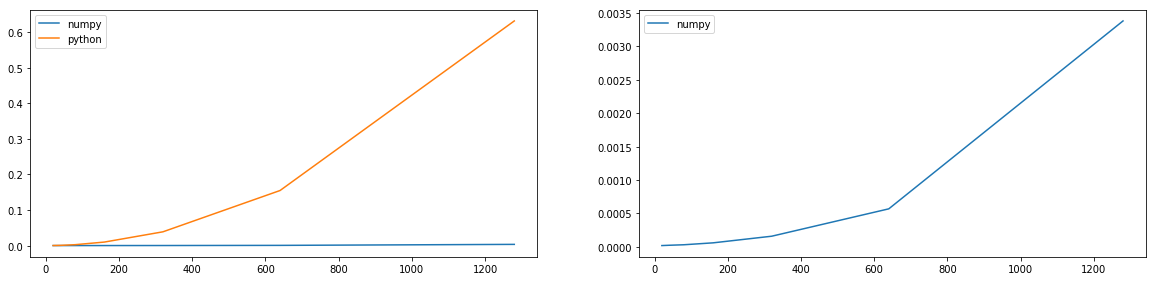

In [8]:
plot_with_legend([results, {"numpy": results["numpy"]}], figure_idx=1, show=True)

## Why is numpy faster?

* *Numpy provides high-performance multidimensional array/matrix/tensor objects*
  1. Strict typing for the arrays
    * Efficiency/performance vs. flexibility
  2. The array operations are run on C-level
  3. (1) and (2) enable [vectorization](https://en.wikipedia.org/wiki/Vector_processor), [pipelining](https://en.wikipedia.org/wiki/Instruction_pipelining) etc.

# TensorFlow
So far we have talked about vanilla Python vs. Numpy arrays. In scientific computing scene, everyone talks about TensorFlow.

TensorFlow is an open source software library for numerical computation. Unlike Numpy, TensorFlow presents computation using **data flow graphs**. The data flow graph consists of **nodes**, which represent **mathematical operations**, and **edges**, which represent the **multidimensional data arrays** (tensors) flowing between them.

#### Why?
The flexibility of data flow graphs allow TensorFlow graphs to be easily deployed one or more CPUs or GPUs in various different platforms, such as desktop, server, or mobile device.

Thus, TensorFlow -- like Numpy, but in a bit different way -- brings **speed** and **convenience** for numerical/scientific computing in Python.

"Originally ... at Google ... for the purposes of conducting machine learning and deep neural networks research, but the system is general enough to be applicable in a wide variety of other domains as well."

In [9]:
def table_sums_tf_graph(table_np, dtype=DEFAULT_DTYPE):
    """Generate tf data flow graph for table sums
    
    Parameters
    ----------
    table_np: table of type np.ndarray format
    
    Returns
    ----------
    ops: list of tensorflow operations (nodes in the graph)
      that can be evaluated
    feed_dict: dictionary of format { <tf.placeholder>: raw_values }
      that can be passed to session.run when evaluating values
    """
    table_tf = tf.constant(table_np, dtype=dtype)

    row_sums_sym = tf.reduce_sum(table_tf, axis=1)
    col_sums_sym = tf.reduce_sum(table_tf, axis=0)
    total_sum_sym = tf.reduce_sum(table_tf)
    
    ops = (row_sums_sym, col_sums_sym, total_sum_sym)
    
    return ops

In [10]:
ops = table_sums_tf_graph(table_np)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    (row_sums_tf, col_sums_tf, total_sum_tf) = session.run(ops)

assert(np.all(row_sums_tf == row_sums))
assert(np.all(col_sums_tf == col_sums))
assert(total_sum_tf == total_sum)

print("row_sums: ", row_sums_tf)
print("col_sums: ", col_sums_tf)
print("total_sum: ", total_sum_tf)

row_sums:  [  82.   93.   54.   26.   33.  346.]
col_sums:  [ 166.  312.   98.   44.   14.]
total_sum:  634.0


In [11]:
timer_tf = TableTestTf(timeit_fn=table_sums_tf_graph)
times_tf = timer_tf.repeat(verbose=True, table_sizes=table_sizes)
results["tensorflow"] = times_tf

TableTestTf
table_sizes=[20, 40, 80, 160, 320, 640, 1280]
repeat=5
number=5
verbose=True

Results:
20: 0.00053; 40: 0.00054; 80: 0.00057; 160: 0.00061; 320: 0.00082; 640: 0.00136; 1280: 0.00333; 


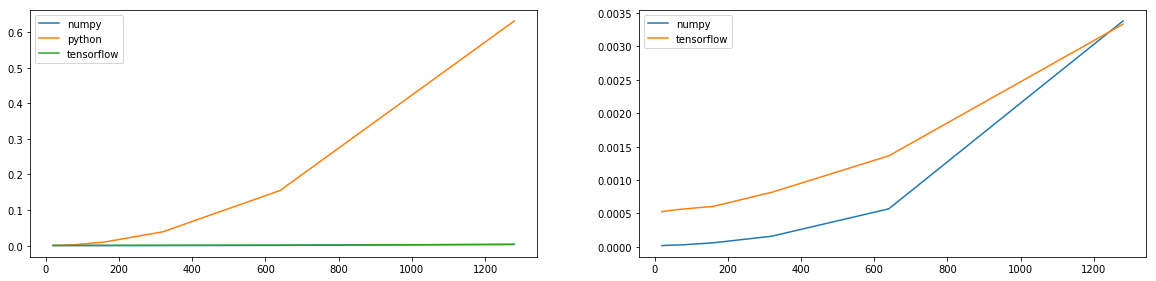

In [12]:
results_without_python = {k:v for k, v in results.items() if k != 'python'}
plot_with_legend([results, results_without_python], figure_idx=2, show=True)

### Why is Numpy still faster?
Because ..

In [17]:
data = np.random.uniform(-1, 1, size=(500, 500)).astype(DEFAULT_DTYPE)
def matrix_power_np(data, power=100):
    new_data = data
    for _ in range(power):
        new_data = np.matmul(new_data, new_data)
    return new_data

def matrix_power_tf(data, power=100):
    tf_data = tf.constant(data)
    def condition(i, new_data):
        return i < power
    
    def body(i, new_data):
        new_data = tf.matmul(new_data, new_data)
        return (i+1), new_data
    
    _, new_data = tf.while_loop(condition, body, [tf.constant(0), tf_data])
    
    return new_data

power = 100
pow_result_np = matrix_power_np(data, 10)
with tf.Session() as sess:
    pow_result_tf = sess.run(matrix_power_tf(data, 10))

np.testing.assert_allclose(pow_result_np, pow_result_tf)

In [14]:
data_sizes = [2**x for x in range(6, 11)] # 64, ..., 16384

mat_pow_timer_np = MatPowTestNp(timeit_fn=matrix_power_np)
mat_pow_times_np = mat_pow_timer_np.repeat(verbose=True,
                                 data_sizes=data_sizes)

mat_pow_timer_tf = MatPowTestTf(timeit_fn=matrix_power_tf)
mat_pow_times_tf = mat_pow_timer_tf.repeat(verbose=True,
                                 data_sizes=data_sizes)


MatPowTestNp
data_sizes=[64, 128, 256, 512, 1024]
repeat=5
number=5
verbose=True

Results:
64: 0.00186; 128: 0.00794; 256: 0.04584; 512: 0.26996; 1024: 2.14610; 
MatPowTestTf
data_sizes=[64, 128, 256, 512, 1024]
repeat=5
number=5
verbose=True

Results:
64: 0.00406; 128: 0.02211; 256: 0.05316; 512: 0.28654; 1024: 2.12739; 


In [15]:
mat_pow_results = {
    "numpy": mat_pow_times_np,
    "tensorflow": mat_pow_times_tf
}

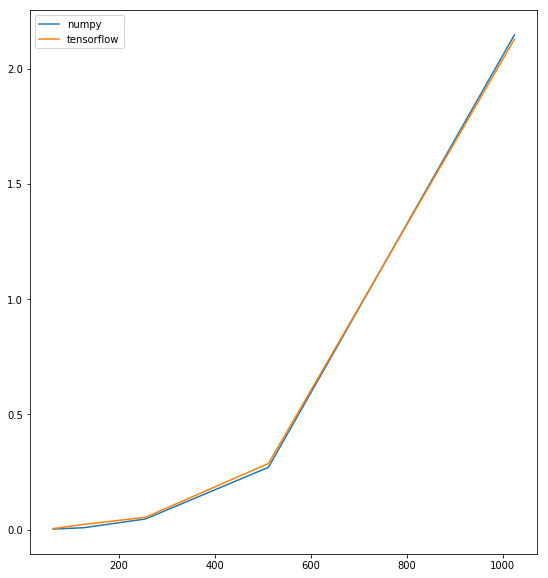

In [16]:
plot_with_legend([mat_pow_results], figure_idx=2, show=True)